In [ ]:
import random
import hashlib
from Bio import SeqIO, Seq, SeqRecord
import mmh3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Simulate reads

In [131]:
def load_reference_genome(fasta_path):
    return SeqIO.to_dict(SeqIO.parse(fasta_path, "fasta"))

def introduce_errors(sequence, sub_rate=0.01, ins_rate=0.1, del_rate=0.02):
    """Introduce substitution, insertion, and deletion errors."""
    bases = ['A', 'C', 'G', 'T']
    i = 0
    result = []

    while i < len(sequence):
        r = random.random()
        if r < sub_rate:
            # Substitution
            original = sequence[i].upper()
            alt = random.choice([b for b in bases if b != original])
            result.append(alt)
            i += 1
        elif r < sub_rate + ins_rate:
            # Insertion
            result.append(random.choice(bases))
            # no increment
        elif r < sub_rate + ins_rate + del_rate:
            # Deletion
            i += 1
        else:
            result.append(sequence[i].upper())
            i += 1
    return ''.join(result)

def simulate_read(genome, chrom, read_length=150, sub_rate=0.01, ins_rate=0.1, del_rate=0.02):
    """Simulate a single read with errors."""
    # chrom = random.choice(list(genome.keys()))
    seq = str(genome[chrom].seq)
    if len(seq) <= read_length:
        raise ValueError(f"Chromosome {chrom} is shorter than the read length.")
    length = min(len(seq), 20000) # Limit to 20kb
    start = random.randint(0, length - read_length)
    read_seq = seq[start:start + read_length]
    error_seq = introduce_errors(read_seq, sub_rate, ins_rate, del_rate)
    return chrom, start, error_seq

def write_fasta(reads, output_path):
    with open(output_path, "w") as f:
        for i, (chrom, start, seq) in enumerate(reads):
            seq = seq.upper()  # Ensure all uppercase
            header = f">sim_read_{chrom}_{start}_{i}"
            f.write(f"{header}\n{seq}\n")


In [132]:
g = load_reference_genome("dros_1.fna")

This shows all the completed sequences in the reference genome

In [133]:
l = {}
for chrom, record in g.items():
    if chrom[0] == 'N' and chrom[1] == 'C':
        print(f"{chrom}: {len(record.seq)} bp")
        l[chrom] = record

NC_004354.4: 23542271 bp
NC_004353.4: 1348131 bp
NC_024512.1: 3667352 bp
NC_024511.2: 19524 bp


In [134]:
fasta_path = "dros_1.fna"
output_fasta = "simulated_reads.fasta"
num_reads = 200
read_length = 500 #10x coverage

genome = load_reference_genome(fasta_path)
reads = []

for _ in range(num_reads):
    chrom, start, read = simulate_read(genome, "NC_024511.2", read_length)
    reads.append((chrom, start, read))

write_fasta(reads, output_fasta)


print(f"Generated {num_reads} simulated reads in FASTA format: {output_fasta}")

Generated 200 simulated reads in FASTA format: simulated_reads.fasta


In [135]:
reads = load_reference_genome("simulated_reads.fasta")
reads.items()


dict_items([('sim_read_NC_024511.2_14658_0', SeqRecord(seq=Seq('ATTTAATTTTATCTAGTTATTAATAAGAATTTTAACTTTAATAATCACTAATAA...CAA'), id='sim_read_NC_024511.2_14658_0', name='sim_read_NC_024511.2_14658_0', description='sim_read_NC_024511.2_14658_0', dbxrefs=[])), ('sim_read_NC_024511.2_12400_1', SeqRecord(seq=Seq('ATGATAAAAACTAAAGAAAAATTGGAGAAATAGTAATGATCTTAAATACATTAG...GGC'), id='sim_read_NC_024511.2_12400_1', name='sim_read_NC_024511.2_12400_1', description='sim_read_NC_024511.2_12400_1', dbxrefs=[])), ('sim_read_NC_024511.2_3402_2', SeqRecord(seq=Seq('TTAGAATATCAGATTTTAATAGATATTGAATTTGATTCAGTAATATAATTCCAA...TTT'), id='sim_read_NC_024511.2_3402_2', name='sim_read_NC_024511.2_3402_2', description='sim_read_NC_024511.2_3402_2', dbxrefs=[])), ('sim_read_NC_024511.2_5399_3', SeqRecord(seq=Seq('GACATTTACAATTAATCACTTCTCAAAAAATCATCATTTATGGTTTTATGAAGC...TTT'), id='sim_read_NC_024511.2_5399_3', name='sim_read_NC_024511.2_5399_3', description='sim_read_NC_024511.2_5399_3', dbxrefs=[])), ('sim_read_N

Compute MinHash

In [136]:
def getkmers(sequence, k):
    return [sequence.seq[i:i + k] for i in range(len(sequence.seq) - k + 1)]

def minhash_signature(kmer_set, num_hashes):
    signature = []
    for i in range(num_hashes):
        min_hash = float('inf')
        for kmer in kmer_set:
            h = mmh3.hash(str(kmer), seed=i) & 0xffffffff
            min_hash = min(min_hash, h)
        signature.append(min_hash)
    return signature

def jaccard_estimate(sig1, sig2):
    return sum(a == b for a, b in zip(sig1, sig2)) / len(sig1)

def verify_pairs(read1, read2, read_length=500):
    indx1 = int(read1.split("_")[4])
    indx2 = int(read2.split("_")[4])
    if abs(indx1 - indx2) <= read_length and abs(indx1 - indx2) > 50:
        return True
    return False

Calculate MinHash

In [137]:
matches = []
num_hashes = 512
count = 0
sig = {}
for key in reads.keys():
    sig[key] = minhash_signature(getkmers(reads[key], 8), num_hashes)
for i, key in enumerate(reads.keys()):
    for j, key2 in enumerate(reads.keys()):
        if i >= j:
            continue
        matches.append((key, key2, jaccard_estimate(sig[key], sig[key2])))

In [138]:
# matchesfile = "jacc_f_big.txt"
# with open(matchesfile, "w") as f:
#     for match in matches:
#         f.write(f"{match[0]}\t{match[1]}\t{match[2]}\n")
count = 0
for key1, key2, jaccard in matches:
    if verify_pairs(key1, key2):
        count += 1
print(f"Number of matches: {count}")
print(f"Total pairs: {len(matches)}")
ac_pairs_read = count
pairs_read = len(matches)

Number of matches: 880
Total pairs: 19900


In [139]:
threshold = 0.01
count = 0
jacc_scores = []
for key, key2, jaccard in matches:
    if float(jaccard) > threshold:
        jacc_scores.append((key, key2, jaccard))
        if verify_pairs(key, key2):
            count += 1
print(count)
print(len(jacc_scores))
ac_pairs_mh = count
pairs_mh = len(jacc_scores)

876
18567


In [140]:
# threshold = 0.01
# count = 0
# jacc_scores = []
# with open("jacc_f.txt", "r") as f:
#     lines = f.readlines()
#     for line in lines:
#         key, key2, jaccard = line.strip().split("\t")
#         if float(jaccard) > threshold:
#             jacc_scores.append((key, key2, jaccard))
#             count += 1
# print(count)


Calculate Overlaps

In [141]:
overlaps = []
for key, key2, jaccard in jacc_scores:
    kmers1 = getkmers(reads[key], 8)
    kmers2 = getkmers(reads[key2], 8)
    sim_count = 0
    indexes = []
    s = {}
    for i, kmer in enumerate(kmers1):
        s[kmer] = i
    for i, kmer in enumerate(kmers2):
        if kmer in s.keys():
            sim_count += 1
            indexes.append((s[kmer], i))
    median = np.median([j-i for i, j in indexes])
    s = {}
    sim_count = 0
    start = 10000000 #arbitrarily large
    end = -1
    if median>0:
        for i, kmer in enumerate(kmers1):
            if i < len(kmers1) - int(median*1.3)+8:
                continue
            s[kmer] = i
        for i, kmer in enumerate(kmers2):
            if i > int(median*1.3) - 8:
                break
            if kmer in s.keys():
                sim_count += 1
                start = min(start, s[kmer]-8)  #k = 8
                end = max(end, i+8)  #k = 8
        if(sim_count>0):
            # print(key, key2, start, end, median, sim_count, 2*sim_count/(end+start))
            overlaps.append((key, key2, start, end, median, sim_count))
    else:
        for i, kmer in enumerate(kmers2):
            if i < len(kmers1) + int(median*1.3)+8:
                continue
            s[kmer] = i
        for i, kmer in enumerate(kmers1):
            if i > -int(median*1.3) - 8:
                break
            if kmer in s.keys():
                sim_count += 1
                start = min(start, s[kmer]-8)
                end = max(end, i+8)
        if(sim_count>0):
            # print(key2, key, start, end, median, sim_count, 2*sim_count/(end+start))
            overlaps.append((key2, key, start, end, median, sim_count))
    
print(len(overlaps))
count = 0
for key, key2, start, end, median, sim_count in overlaps:
    if verify_pairs(key, key2):
        count += 1
print("correct: ",count)
pairs_ck = len(overlaps)

6382
correct:  675


In [ ]:
def verify_overlap(key, key2, start, end):
    if start < 0 or end < 0:
        return False
    indx1 = int(key.split("_")[4]) # the string contains the index from which the read was taken
    indx2 = int(key2.split("_")[4])
    avg = (start + end)/2
    if (indx1 - indx2 > avg - 200) and (indx1 - indx2 < avg + 200):
        return True
    return False

In [143]:
count = 0
for key, key2, start, end, median, sim_count in overlaps:
    if verify_overlap(key, key2, start, end):
        count += 1
print("detected & correct:", count)
ac_pairs_ck = count
count = 0
conf_overlaps = [i for i in overlaps if (2*i[5])/(i[2]+i[3]) > 0.03]
print(f"conf_overlaps: {len(conf_overlaps)}")
pairs_sim = len(conf_overlaps)
for key, key2, start, end, median, sim_count in conf_overlaps:
    if verify_overlap(key, key2, start, end):
        # print(key, key2, start, end, median, sim_count)
        count += 1
    # else:
        # print(key, key2, start, end, median, sim_count)
print(count)
ac_pairs_sim = count

detected & correct: 543
conf_overlaps: 745
293


Train classifier

In [144]:
x = []
y = []

for key, key2, start, end, median, sim_count in conf_overlaps:
    if verify_overlap(key, key2, start, end):
        x.append([start, end, median, 2*sim_count/(end+start)])
        y.append(1)
    else:
        x.append([start, end, median, 2*sim_count/(end+start)])
        y.append(0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", rf.score(x_test, y_test))


              precision    recall  f1-score   support

           0       0.85      0.91      0.88        90
           1       0.85      0.76      0.80        59

    accuracy                           0.85       149
   macro avg       0.85      0.84      0.84       149
weighted avg       0.85      0.85      0.85       149

[[82  8]
 [14 45]]
Accuracy: 0.8523489932885906


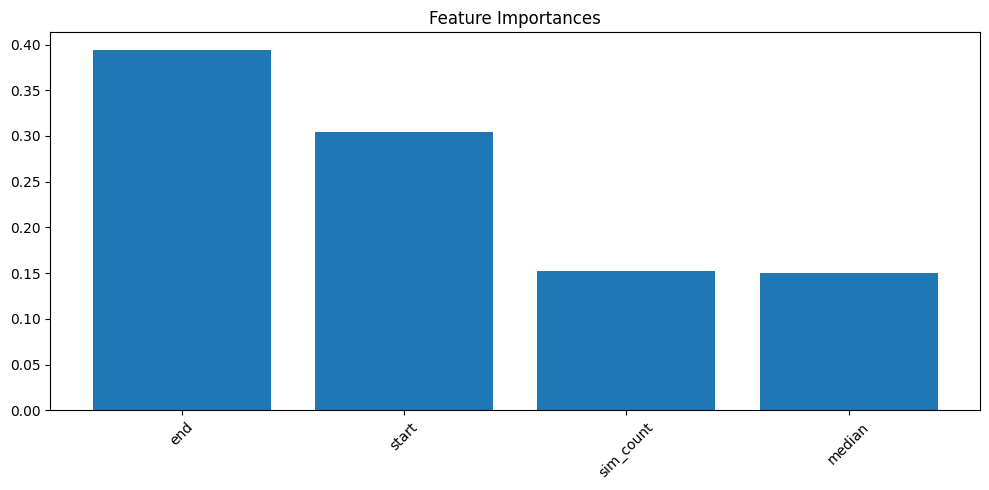

In [145]:
importances = rf.feature_importances_
feature_names = ["start", "end", "median", "sim_count"]
sorted_indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(4), importances[sorted_indices], align='center')
plt.xticks(range(4), [feature_names[i] for i in sorted_indices], rotation=45)
plt.tight_layout()
plt.show()

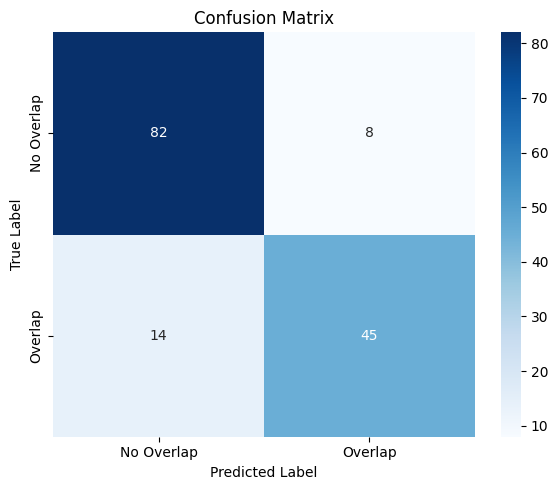

In [146]:
labels = ["No Overlap", "Overlap"]
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Do the same for another input for testing

In [155]:
fasta_path = "dros_1.fna"
output_fasta = "test_reads.fasta"
num_reads = 200
read_length = 500 #10x coverage

genome = load_reference_genome(fasta_path)
reads = []

for _ in range(num_reads):
    chrom, start, read = simulate_read(genome, "NC_004353.4", read_length)
    reads.append((chrom, start, read))

write_fasta(reads, output_fasta)


print(f"Generated {num_reads} simulated reads in FASTA format: {output_fasta}")

Generated 200 simulated reads in FASTA format: test_reads.fasta


In [156]:
reads = load_reference_genome("test_reads.fasta")
reads.items()

dict_items([('sim_read_NC_004353.4_14371_0', SeqRecord(seq=Seq('ACTCTCGTAACAGATGGAATTGCTGAAAATAAAAAATAAAAAAAACAAAAGAAC...TTT'), id='sim_read_NC_004353.4_14371_0', name='sim_read_NC_004353.4_14371_0', description='sim_read_NC_004353.4_14371_0', dbxrefs=[])), ('sim_read_NC_004353.4_2743_1', SeqRecord(seq=Seq('AGCATTTGACTGAAATTCCCTTTTAATTCGAACGGATAAAGTGATCAAGTATGT...GCC'), id='sim_read_NC_004353.4_2743_1', name='sim_read_NC_004353.4_2743_1', description='sim_read_NC_004353.4_2743_1', dbxrefs=[])), ('sim_read_NC_004353.4_2760_2', SeqRecord(seq=Seq('TTTAATTCAACGGAACAAGTATCAAGTGTCTGTTCACGAATTTAATTCAAGCGA...TAC'), id='sim_read_NC_004353.4_2760_2', name='sim_read_NC_004353.4_2760_2', description='sim_read_NC_004353.4_2760_2', dbxrefs=[])), ('sim_read_NC_004353.4_10339_3', SeqRecord(seq=Seq('GTATAGTTAAAAATAGCATGCAGGGTTGCCGGTGCGTAGCGAACGGAGTTTGAT...CGA'), id='sim_read_NC_004353.4_10339_3', name='sim_read_NC_004353.4_10339_3', description='sim_read_NC_004353.4_10339_3', dbxrefs=[])), ('sim_read_N

In [157]:
matches = []
num_hashes = 512
count = 0
sig = {}
for key in reads.keys():
    sig[key] = minhash_signature(getkmers(reads[key], 8), num_hashes)
for i, key in enumerate(reads.keys()):
    for j, key2 in enumerate(reads.keys()):
        if i >= j:
            continue
        matches.append((key, key2, jaccard_estimate(sig[key], sig[key2])))

In [158]:
threshold = 0.01
count = 0
jacc_scores = []
for key, key2, jaccard in matches:
    if float(jaccard) > threshold:
        jacc_scores.append((key, key2, jaccard))
        count += 1
print(count)

6519


In [159]:
overlaps = []
for key, key2, jaccard in jacc_scores:
    kmers1 = getkmers(reads[key], 8)
    kmers2 = getkmers(reads[key2], 8)
    sim_count = 0
    indexes = []
    s = {}
    for i, kmer in enumerate(kmers1):
        s[kmer] = i
    for i, kmer in enumerate(kmers2):
        if kmer in s.keys():
            sim_count += 1
            indexes.append((s[kmer], i))
    median = np.median([j-i for i, j in indexes])
    s = {}
    sim_count = 0
    start = 10000000 #arbitrarily large
    end = -1
    if median>0:
        for i, kmer in enumerate(kmers1):
            if i < len(kmers1) - int(median*1.3)+8:
                continue
            s[kmer] = i
        for i, kmer in enumerate(kmers2):
            if i > int(median*1.3) - 8:
                break
            if kmer in s.keys():
                sim_count += 1
                start = min(start, s[kmer]-8)  #k = 8
                end = max(end, i+8)  #k = 8
        if(sim_count>0):
            # print(key, key2, start, end, median, sim_count, 2*sim_count/(end+start))
            overlaps.append((key, key2, start, end, median, sim_count))
    else:
        for i, kmer in enumerate(kmers2):
            if i < len(kmers1) + int(median*1.3)+8:
                continue
            s[kmer] = i
        for i, kmer in enumerate(kmers1):
            if i > -int(median*1.3) - 8:
                break
            if kmer in s.keys():
                sim_count += 1
                start = min(start, s[kmer]-8)
                end = max(end, i+8)
        if(sim_count>0):
            # print(key2, key, start, end, median, sim_count, 2*sim_count/(end+start))
            overlaps.append((key2, key, start, end, median, sim_count))
    
print(len(overlaps))


2207


In [160]:
count = 0
conf_overlaps = [i for i in overlaps if (2*i[5])/(i[2]+i[3]) > 0.03]
print(len(conf_overlaps))
for key, key2, start, end, median, sim_count in conf_overlaps:
    if verify_overlap(key, key2, start, end):
        # print(key, key2, start, end, median, sim_count)
        count += 1
    # else:
        # print(key, key2, start, end, median, sim_count)
print(count)

319
208


In [161]:
x = []
y = []
for key, key2, start, end, median, sim_count in conf_overlaps:
    if verify_overlap(key, key2, start, end):
        x.append([start, end, median, 2*sim_count/(end+start)])
        y.append(1)
    else:
        x.append([start, end, median, 2*sim_count/(end+start)])
        y.append(0)
pred = rf.predict(x)
print(classification_report(y, pred))
print(confusion_matrix(y, pred))
print("Accuracy:", rf.score(x, y))

              precision    recall  f1-score   support

           0       0.76      0.58      0.66       111
           1       0.80      0.90      0.85       208

    accuracy                           0.79       319
   macro avg       0.78      0.74      0.75       319
weighted avg       0.79      0.79      0.78       319

[[ 64  47]
 [ 20 188]]
Accuracy: 0.7899686520376176


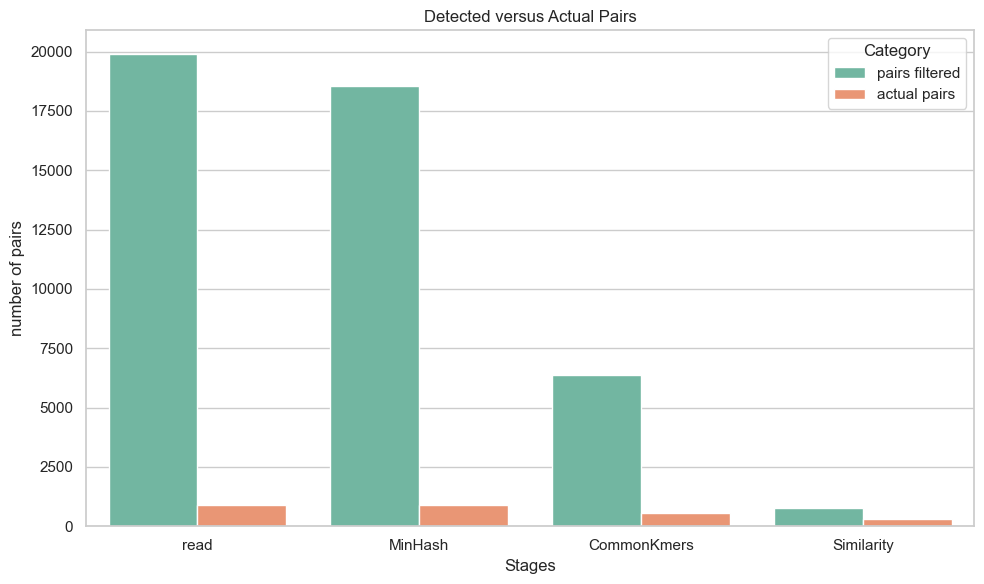

In [170]:
dta = {
    "stage": ["read", "MinHash", "CommonKmers", "Similarity"],
    "pairs filtered": [pairs_read, pairs_mh, pairs_ck, pairs_sim],
    "actual pairs": [ac_pairs_read, ac_pairs_mh, ac_pairs_ck, ac_pairs_sim]
}
df_wide = pd.DataFrame(dta)

df_long = pd.melt(df_wide, id_vars="stage", 
                  value_vars=['pairs filtered', 'actual pairs'],
                  var_name='pairs', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='stage', y='Value', hue='pairs', palette='Set2')

# Add labels and title
plt.title("Detected versus Actual Pairs")
plt.xlabel("Stages")
plt.ylabel("number of pairs")
plt.legend(title='Category')
plt.tight_layout()
plt.show()

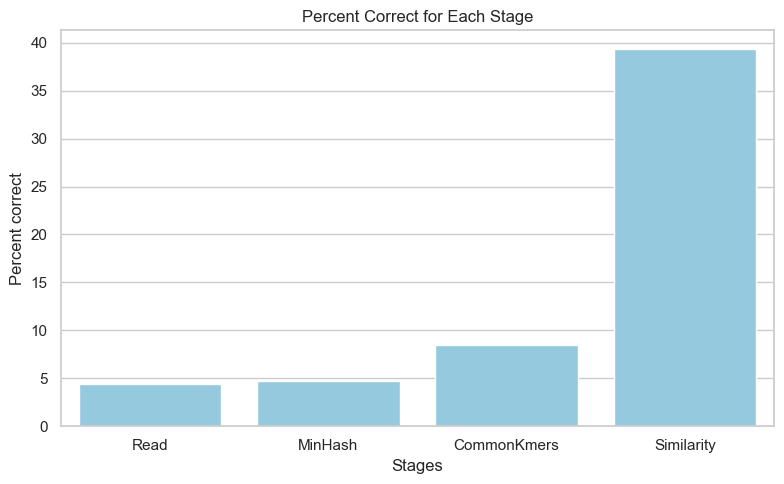

In [171]:
data = {
    'Group': ['Read', 'MinHash', 'CommonKmers', 'Similarity'],
    'Percent correct': [(ac_pairs_read/pairs_read)*100,(ac_pairs_mh/pairs_mh)*100, (ac_pairs_ck/pairs_ck)*100, (ac_pairs_sim/pairs_sim)*100]
}
df = pd.DataFrame(data)

sns.set_theme(style="whitegrid")

# Create bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Group', y='Percent correct', color='skyblue')

# Add labels and title
plt.title("Percent Correct for Each Stage")
plt.xlabel("Stages")
plt.ylabel("Percent correct")

plt.tight_layout()
plt.show()